# 미세먼지 농도 예측

* AirkKorea 미세먼지 데이터 활용  
 - 춘천시 석사동 지역의 한달간 미세먼지농도 데이터를 수집
 - 12시간 미세먼지 측정값을 이용하여 1시간 후 미세먼지농도를 예측   

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## 미세먼지 dataset

지역 : 석사동
기간 : 20200616 ~ 20200717
관측값 : 미세먼지(PM10), 초미세먼지(PM2.5), 오존(O3), 이산화질소(NO2), 일산화탄소(CO), 아황산가스(SO2)

예측 : 12시간 이전 값으로 한시간 이후 예측
윈도우 : 입력 : 12시간 데이터, 출력 :  한시간 후 데이터


In [2]:
#csv_path = '/content/drive/My Drive/DeepLearning/data/pmdata_20200617_0717.csv'
csv_path = './data/pmdata_20200617_0717.csv'
df = pd.read_csv(csv_path)

In [3]:
# 상위 데이터 목록 확인
df.head()


,DateTime,PM10,PM2_5,O3,NO2,CO,SO2
0,2020-07-17:14,27.0,19.0,0.056,0.005,0.4,0.002
1,2020-07-17:13,28.0,22.0,0.059,0.006,0.4,0.002
2,2020-07-17:12,33.0,22.0,0.050,0.008,0.4,0.002
3,2020-07-17:11,32.0,19.0,0.032,0.010,0.4,0.002
4,2020-07-17:10,28.0,15.0,0.018,0.009,0.4,0.002


In [6]:
#데이터프레임 정보확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DateTime  734 non-null    object 
 1   PM10      731 non-null    float64
 2   PM2_5     675 non-null    float64
 3   O3        731 non-null    float64
 4   NO2       731 non-null    float64
 5   CO        731 non-null    float64
 6   SO2       713 non-null    float64
dtypes: float64(6), object(1)
memory usage: 40.4+ KB


In [7]:
#데이터 통계값 확인
df.describe()

,PM10,PM2_5,O3,NO2,CO,SO2
count,731.000000,675.000000,731.000000,731.000000,731.000000,713.000000
mean,24.429549,15.180741,0.039747,0.007798,0.371956,0.001533
std,15.475262,10.625396,0.021559,0.004194,0.088944,0.000545
min,2.000000,1.000000,0.001000,0.001000,0.200000,0.001000
25%,12.000000,7.000000,0.026000,0.004000,0.300000,0.001000
50%,23.000000,14.000000,0.037000,0.007000,0.400000,0.002000
75%,34.000000,22.000000,0.051000,0.010000,0.400000,0.002000
max,81.000000,48.000000,0.129000,0.025000,0.700000,0.004000


In [8]:
#datetime index 설정
df.index = df['DateTime']

print(df.head())
print(df.shape)

                    DateTime  PM10  PM2_5     O3    NO2   CO    SO2
DateTime                                                           
2020-07-17:14  2020-07-17:14  27.0   19.0  0.056  0.005  0.4  0.002
2020-07-17:13  2020-07-17:13  28.0   22.0  0.059  0.006  0.4  0.002
2020-07-17:12  2020-07-17:12  33.0   22.0  0.050  0.008  0.4  0.002
2020-07-17:11  2020-07-17:11  32.0   19.0  0.032  0.010  0.4  0.002
2020-07-17:10  2020-07-17:10  28.0   15.0  0.018  0.009  0.4  0.002
(737, 7)


In [9]:
#결측치 확인 및 삭제
na = df.isnull().sum()
print("NA = ", na)
df.dropna(inplace=True)
print(df.shape)


NA =  DateTime     3
PM10         6
PM2_5       62
O3           6
NO2          6
CO           6
SO2         24
dtype: int64
(662, 7)


In [10]:
#날짜순으로 정렬
df = df.sort_index(ascending=True)
print(df)

                    DateTime  PM10  PM2_5     O3    NO2   CO    SO2
DateTime                                                           
2020-06-17:01  2020-06-17:01  48.0   29.0  0.052  0.015  0.5  0.002
2020-06-17:02  2020-06-17:02  57.0   31.0  0.042  0.016  0.5  0.002
2020-06-17:03  2020-06-17:03  56.0   33.0  0.036  0.014  0.5  0.001
2020-06-17:04  2020-06-17:04  58.0   39.0  0.032  0.013  0.5  0.001
2020-06-17:05  2020-06-17:05  57.0   39.0  0.028  0.011  0.5  0.002
...                      ...   ...    ...    ...    ...  ...    ...
2020-07-17:10  2020-07-17:10  28.0   15.0  0.018  0.009  0.4  0.002
2020-07-17:11  2020-07-17:11  32.0   19.0  0.032  0.010  0.4  0.002
2020-07-17:12  2020-07-17:12  33.0   22.0  0.050  0.008  0.4  0.002
2020-07-17:13  2020-07-17:13  28.0   22.0  0.059  0.006  0.4  0.002
2020-07-17:14  2020-07-17:14  27.0   19.0  0.056  0.005  0.4  0.002

[662 rows x 7 columns]


(662,)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000F8248D0>],
      dtype=object)

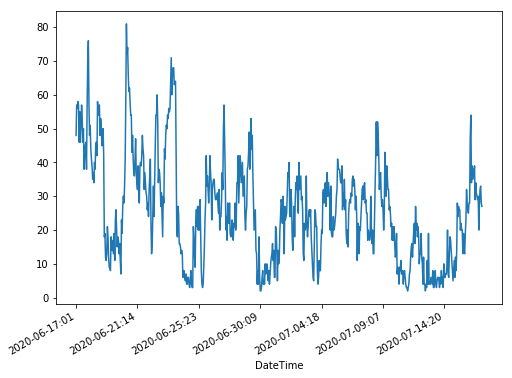

In [11]:
#미세먼지 값만 추출
uni_data=df["PM10"]
uni_data.index = df['DateTime']
uni_data.head()

print(uni_data.shape)

#그래프로 확인
uni_data.plot(subplots=True)


데이터의 처음 500 개는 학습 데이터 세트고 나머지는 유효성 검사 데이터 세트로 구성

In [12]:
#학습 데이터 분리를 위한 위치값
TRAIN_SPLIT = 500

재현성을 보장하기 위해 시드 설정.

In [13]:
tf.random.set_seed(13)

### (3)Standardization  
평균, 표준편차를 구하여 스케일링 처리  
keras.utils.normalize를 이용하여 [0,1] 범위로 재조정 하는 방법을 사용해도됨

In [14]:
#uni_data에서 값만 추출
uni_data = uni_data.values

#평균, 표준편차 구하기
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [15]:
#Standardization (표준화)
uni_data = (uni_data-uni_train_mean)/uni_train_std

### (4) univariate_data 추출


* univariate_data 함수  
모델이 학습할 때 사용할 window를 반환  
매개 변수 history_size : 과거 정보 window size, target_size : 예측  레이블.

In [15]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

* window 추출  
x : 지난 12 개의 PM10 관측값  
y : 1시간 이후 관측값

In [16]:
univariate_past_history = 12
univariate_future_target = 1

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

print("train data :", x_train_uni.shape)
print("validation data : ", x_val_uni.shape)


train data : (488, 12, 1)
validation data :  (149, 12, 1)


In [17]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[1.2409587 ]
 [1.82496981]
 [1.76007968]
 [1.88985993]
 [1.82496981]
 [1.11117846]
 [1.69518956]
 [1.11117846]
 [1.43562907]
 [1.82496981]
 [1.56540932]
 [1.11117846]]

 Target temperature to predict
0.5920574781936239


### (5) 예측확인 그래프

In [31]:
def create_time_steps(length):
  return list(range(-length, 0))

In [32]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'C:\\Program Files\\Anaconda201812\\lib\\site-packages\\matplotlib\\pyplot.py'>

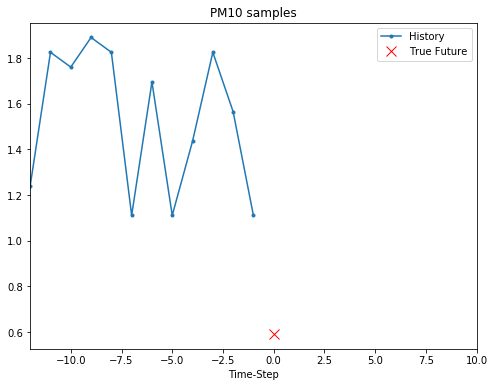

In [20]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'PM10 samples')

### (5) Baseline
모델 학습전에 기준선 결정, 과거 20개 관측값의 평균점을 모델 예측으로 정하여 출력

In [21]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Program Files\\Anaconda201812\\lib\\site-packages\\matplotlib\\pyplot.py'>

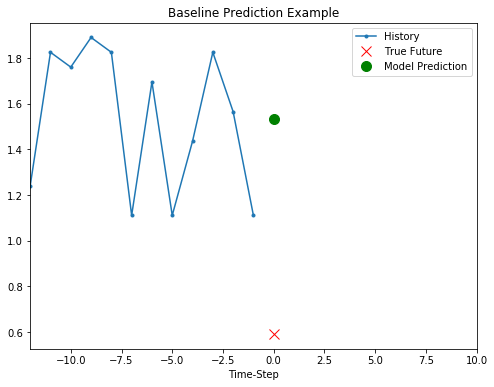

In [22]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

## Recurrent neural network

LSTM 을 사용하여 예측모델 구성

### (6) LSTM 입력 데이터 구조 

In [23]:
BATCH_SIZE = 50
BUFFER_SIZE = 500

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

### (7) LSTM model 구성

In [24]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),         #output unit size = 8
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')   #regression

### (8) sample prediction

모든 데이터를 예측하여  모델의 출력 결과  확인

In [25]:
for x, y in val_univariate.take(1):
    pred = simple_lstm_model.predict(x)
print(pred.shape)

(50, 1)


<module 'matplotlib.pyplot' from 'C:\\Program Files\\Anaconda201812\\lib\\site-packages\\matplotlib\\pyplot.py'>

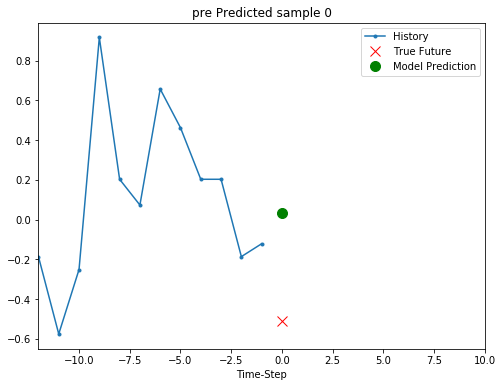

In [26]:
show_plot([x[0].numpy(), y[0].numpy(), pred[0]], 0, 'pre Predicted sample 0')

### (9)모델 학습

In [27]:
EVALUATION_INTERVAL = 50
EPOCHS = 100

history = simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=10)

Train for 50 steps, validate for 10 steps
Epoch 1/100
50/50 [==============================] - 2s 41ms/step - loss: 0.7146 - val_loss: 0.6835
Epoch 2/100
50/50 [==============================] - 0s 5ms/step - loss: 0.6438 - val_loss: 0.5507
Epoch 3/100
50/50 [==============================] - 0s 5ms/step - loss: 0.5976 - val_loss: 0.4668
Epoch 4/100
50/50 [==============================] - 0s 5ms/step - loss: 0.5538 - val_loss: 0.3936
Epoch 5/100
50/50 [==============================] - 0s 5ms/step - loss: 0.5167 - val_loss: 0.3254
Epoch 6/100
50/50 [==============================] - 0s 5ms/step - loss: 0.4898 - val_loss: 0.3011
Epoch 7/100
50/50 [==============================] - 0s 5ms/step - loss: 0.4706 - val_loss: 0.2863
Epoch 8/100
50/50 [==============================] - 0s 5ms/step - loss: 0.4545 - val_loss: 0.2840
Epoch 9/100
50/50 [==============================] - 0s 5ms/step - loss: 0.4420 - val_loss: 0.2723
Epoch 10/100
50/50 [==============================] - 0s 5ms/step 

In [30]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

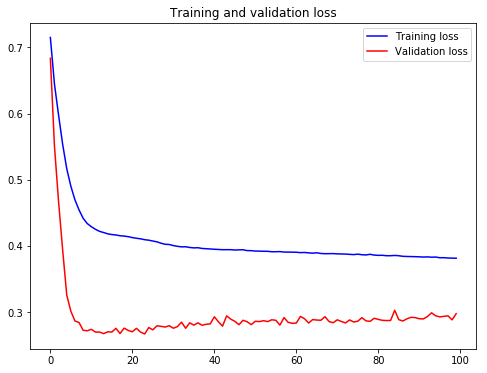

In [30]:
plot_train_history(history, 'Training and validation loss')

### (10)학습된 LSTM으로 예측결과 확인

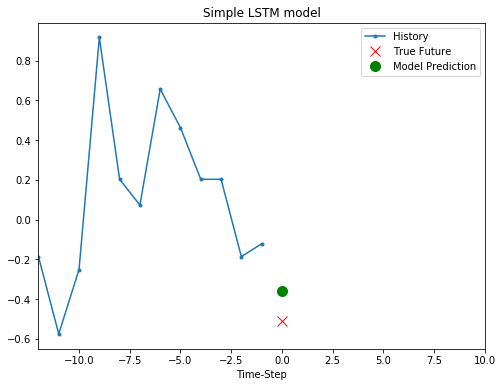

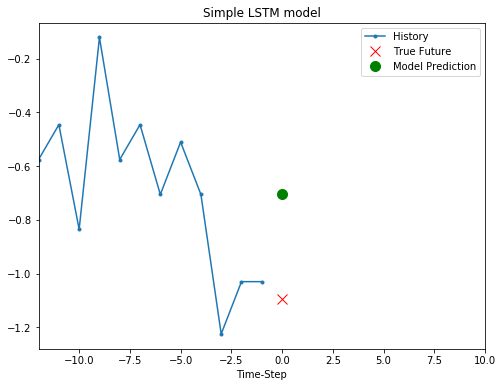

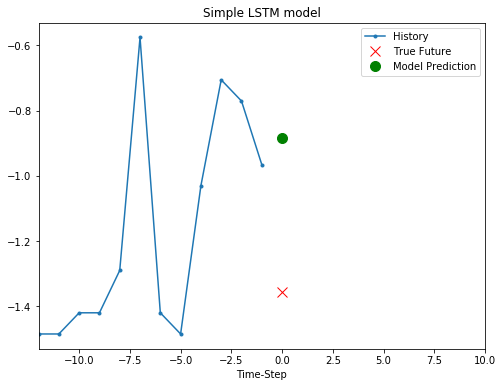

In [31]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

In [35]:
# 모델 평가하기
trainScore = simple_lstm_model.evaluate(x_train_uni, y_train_uni, verbose=0)
print('Train Score: ', trainScore)
valScore = simple_lstm_model.evaluate(x_val_uni, y_val_uni, verbose=0)
print('Validataion Score: ', valScore)

Train Score:  0.38060222101993246
Validataion Score:  0.2993281845678419


## II. 3개 특징으로 예측

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 662 entries, 2020-06-17:01 to 2020-07-17:14
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DateTime  662 non-null    object 
 1   PM10      662 non-null    float64
 2   PM2_5     662 non-null    float64
 3   O3        662 non-null    float64
 4   NO2       662 non-null    float64
 5   CO        662 non-null    float64
 6   SO2       662 non-null    float64
dtypes: float64(6), object(1)
memory usage: 41.4+ KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000F93D518>,
      dtype=object)

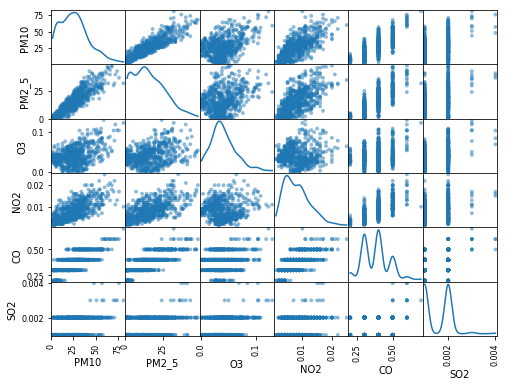

In [17]:
pd.plotting.scatter_matrix(df, s=60, diagonal='kde')

### (1) 3개의 특징으로 구성된 데이터 생성

In [18]:
features_considered = ['PM10', 'O3', 'NO2']

In [19]:
features = df[features_considered]
features.index = df['DateTime']
features.head()

,PM10,O3,NO2
DateTime,,,
2020-06-17:01,48.0,0.052,0.015
2020-06-17:02,57.0,0.042,0.016
2020-06-17:03,56.0,0.036,0.014
2020-06-17:04,58.0,0.032,0.013
2020-06-17:05,57.0,0.028,0.011


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000F8FD898>,
      dtype=object)

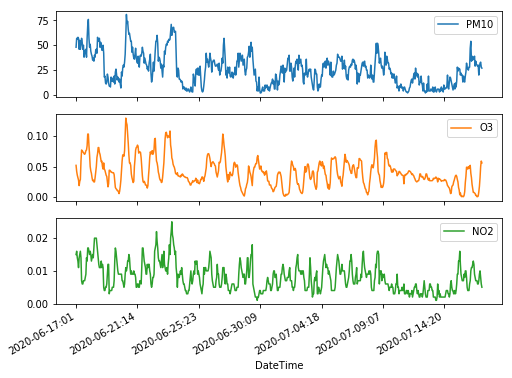

In [20]:
features.plot(subplots=True)

### (2) 표준화 

In [21]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [22]:
dataset = (dataset-data_mean)/data_std

### (3) Single step model
과거기록으로부터 단일지점 예측

step만큼 과거 관측치 샘플링

In [23]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [24]:
past_history = 12
future_target = 1
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [25]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))


Single window of past history : (12, 3)


In [26]:
BATCH_SIZE = 50
BUFFER_SIZE = 500

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

### (4)모델 구성

In [27]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
#single_step_model.add(tf.keras.layers.Dropout(0.3))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

### (5) sample prediction.

In [28]:
for x, y in val_data_single.take(1):
  pred = single_step_model.predict(x)
  print(pred.shape)

(50, 1)


<module 'matplotlib.pyplot' from 'C:\\Program Files\\Anaconda201812\\lib\\site-packages\\matplotlib\\pyplot.py'>

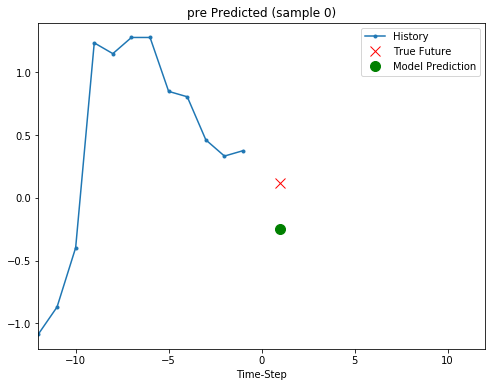

In [33]:
show_plot([x[0][:, 1].numpy(), y[0].numpy(), pred[0]], future_target, 'pre Predicted (sample 0)')

### (6)모델 학습

In [34]:
EVALUATION_INTERVAL = 50
EPOCHS = 20

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=20)

Train for 50 steps, validate for 20 steps
Epoch 1/20
50/50 [==============================] - 2s 43ms/step - loss: 0.7127 - val_loss: 0.3645
Epoch 2/20
50/50 [==============================] - 0s 5ms/step - loss: 0.5006 - val_loss: 0.2803
Epoch 3/20
50/50 [==============================] - 0s 5ms/step - loss: 0.4205 - val_loss: 0.2513
Epoch 4/20
50/50 [==============================] - 0s 5ms/step - loss: 0.3804 - val_loss: 0.2457
Epoch 5/20
50/50 [==============================] - 0s 5ms/step - loss: 0.3509 - val_loss: 0.2411
Epoch 6/20
50/50 [==============================] - 0s 5ms/step - loss: 0.3254 - val_loss: 0.2313
Epoch 7/20
50/50 [==============================] - 0s 5ms/step - loss: 0.3124 - val_loss: 0.2173
Epoch 8/20
50/50 [==============================] - 0s 5ms/step - loss: 0.3003 - val_loss: 0.2333
Epoch 9/20
50/50 [==============================] - 0s 5ms/step - loss: 0.2887 - val_loss: 0.2184
Epoch 10/20
50/50 [==============================] - 0s 5ms/step - loss: 0.

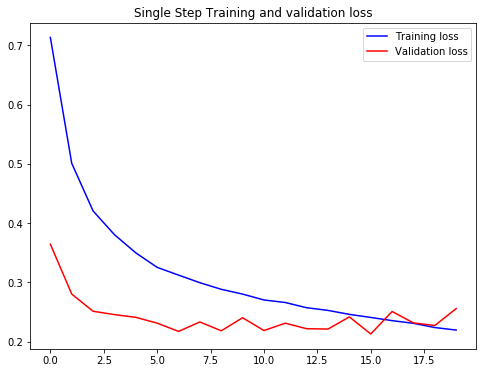

In [35]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

(7) Predict a single step future
12시간 (12 개 데이터 포인트)으로 샘플링 된 3 가지 특징의 예측

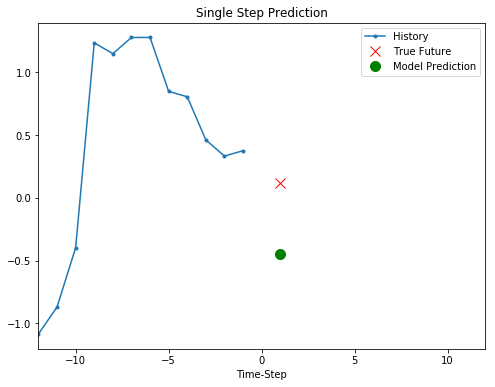

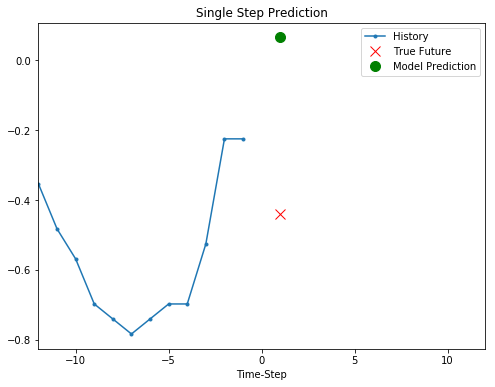

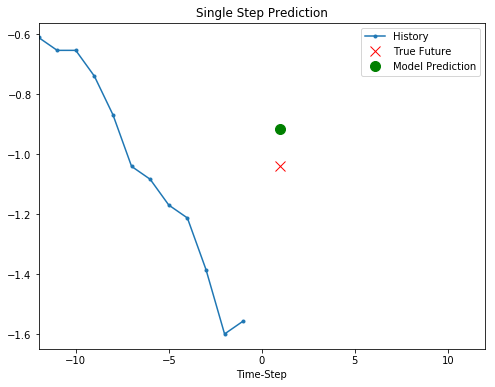

In [36]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], future_target,
                   'Single Step Prediction')
  plot.show()

  

### 모델 평가

In [37]:
# 모델 평가하기
trainScore = single_step_model.evaluate(x_train_single, y_train_single, verbose=0)
print('Train Score: ', trainScore)
valScore = single_step_model.evaluate(x_val_single, y_val_single, verbose=0)
print('Validataion Score: ', valScore)


Train Score:  0.2148982073928489
Validataion Score:  0.25814609679599737
